In [7]:
import sys
dirname = '/Users/muhammaddaffarobani/Documents/personal_research/smt'
if dirname not in sys.path:
    sys.path.append(dirname)

import pandas as pd
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import WingWeight
from smt.sampling_methods import LHS
from sklearn.metrics import mean_squared_error


from smt.applications.explainability_tools import (
    PartialDependenceDisplay, 
    PDFeatureImportanceDisplay, 
    PDFeatureInteractionDisplay,
    ShapFeatureImportanceDisplay,
    ShapDisplay,
)

from smt.utils.design_space import (
    DesignSpace,
    FloatVariable,
    CategoricalVariable,
)

import matplotlib.pyplot as plt


In [17]:
def interaction_test_function(x):
    y = 0
    if x[1] < 5:
        y += 10 * x[0]
    else:
        y += 2 * x[0]

    y += 3 * x[1] + 8 * np.sin(x[2])

    return y

In [26]:
ds = DesignSpace([
    FloatVariable(0.0, 10.0),
    FloatVariable(0.0, 10.0),
    FloatVariable(-4, 4),
])

fun = interaction_test_function
# Create training and testing data
n_data = 250
n_train = int(0.8 * n_data)
n_test = n_data - n_train
X, _ = ds.sample_valid_x(n_data)
y = [fun(X[i]) for i in range(len(X))]
y = np.array(y)

n_train = int(0.8 * n_data)

X_tr, y_tr = X[:n_train, :], y[:n_train]
X_te, y_te = X[n_train:, :], y[n_train:]

In [28]:
class GroundTruthModel:
    def predict_values(self, X):
        y = list()
        for i in range(len(X)):
            y.append(fun(X[i]))
        return np.array(y)

In [29]:
%%time
sm = KRG(
    theta0=[1e-2]*X_tr.shape[1],
    print_prediction = False
    )
sm.set_training_values(
    X_tr, 
    y_tr
    )

sm.train()

print("Surrogate model")
y_pred = sm.predict_values(X_te)
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")

print("Ground truth model")
gtm = GroundTruthModel()
y_pred = gtm.predict_values(X_te)   
rmse = mean_squared_error(y_te, y_pred, squared=False)
rrmse = rmse / y_te.mean()
print(f"RMSE: {rmse:.4f}")
print(f"rRMSE: {rrmse:.4f}")


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 200
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.5236731
Surrogate model
RMSE: 9.7840
rRMSE: 0.2168
Ground truth model
RMSE: 0.0000
rRMSE: 0.0000
CPU times: user 10.1 s, sys: 414 ms, total: 10.5 s
Wall time: 1.54 s


CPU times: user 9.2 s, sys: 271 ms, total: 9.47 s
Wall time: 1.33 s


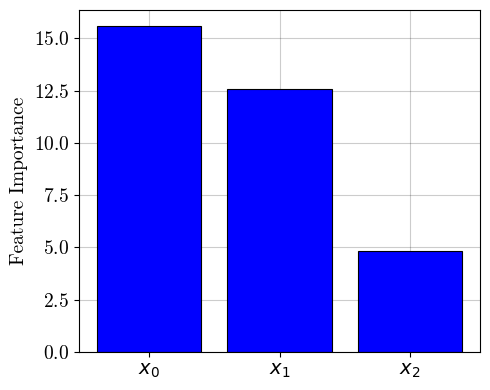

In [31]:
%%time
model = sm
X = X_tr

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    sm, 
    X, 
    # feature_names=feature_names,
)

CPU times: user 9.6 s, sys: 479 ms, total: 10.1 s
Wall time: 1.42 s


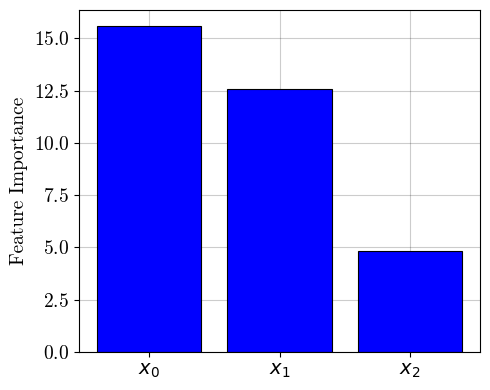

In [32]:
%%time
model = gtm
X = X_tr

feature_importance = PDFeatureImportanceDisplay.from_surrogate_model(
    sm, 
    X, 
    # feature_names=feature_names,
)

CPU times: user 489 ms, sys: 3.21 ms, total: 492 ms
Wall time: 167 ms


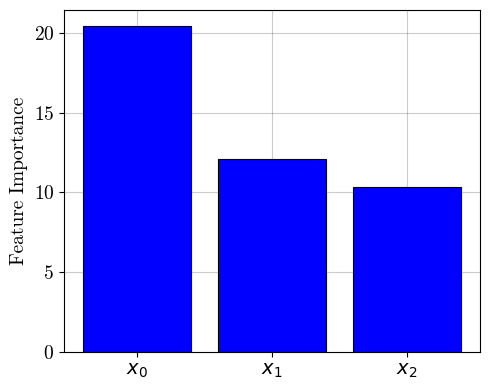

In [33]:
%%time
model = sm
X = X_tr

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    # feature_names=feature_names,
)


CPU times: user 436 ms, sys: 30.2 ms, total: 467 ms
Wall time: 156 ms


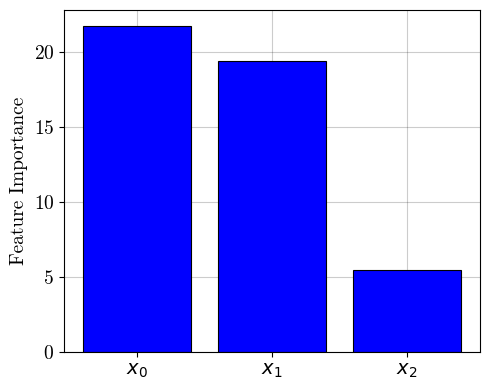

In [34]:
%%time
model = gtm
X = X_tr

feature_importance = ShapFeatureImportanceDisplay.from_surrogate_model(
    model, 
    X, 
    # feature_names=feature_names,
)


CPU times: user 36.2 s, sys: 1.13 s, total: 37.3 s
Wall time: 5.36 s


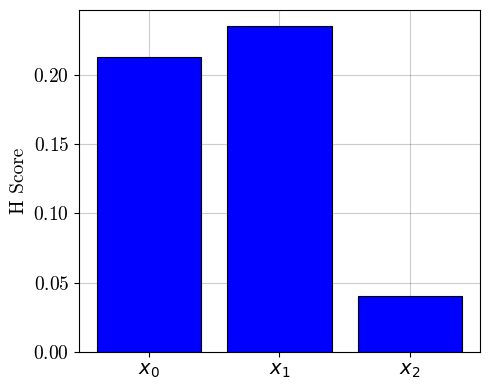

In [36]:
%%time
model = sm
X = X_tr

overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    model,
    X,
    # feature_names=feature_names, 
)

CPU times: user 395 ms, sys: 4.43 ms, total: 400 ms
Wall time: 372 ms


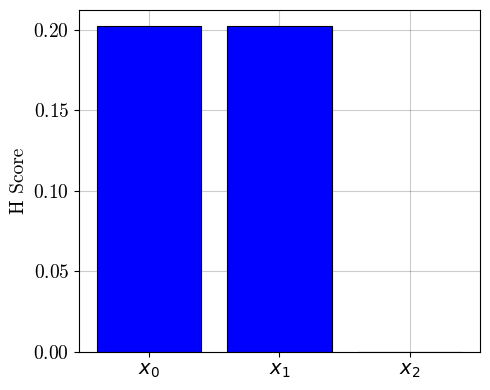

In [37]:
%%time
model = gtm
X = X_tr

overall_pd_interaction = PDFeatureInteractionDisplay.overall_interaction(
    model,
    X,
    # feature_names=feature_names, 
)

CPU times: user 33 s, sys: 1.15 s, total: 34.1 s
Wall time: 4.65 s


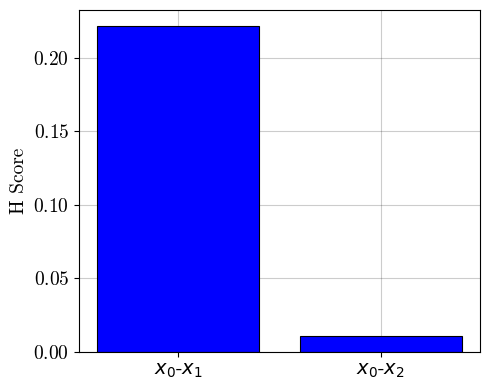

In [38]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
feature_i = 0
feature_pairs = [
    (feature_i, feature_j) for feature_j in features if feature_j != feature_i
]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    model,
    X,
    feature_pairs,
    # feature_names=feature_names,
)

CPU times: user 392 ms, sys: 3.87 ms, total: 396 ms
Wall time: 371 ms


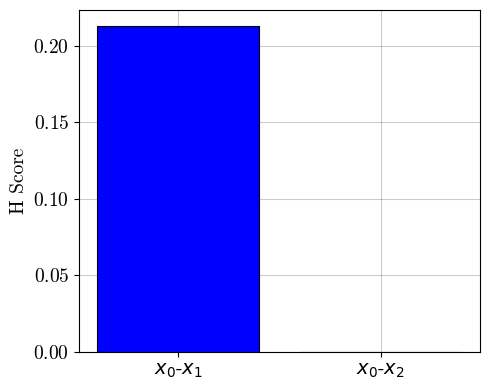

In [39]:
%%time
model = gtm
X = X_tr
features = [i for i in range(X_tr.shape[1])]
feature_i = 0
feature_pairs = [
    (feature_i, feature_j) for feature_j in features if feature_j != feature_i
]

pairwise_pd_interaction = PDFeatureInteractionDisplay.pairwise_interaction(
    model,
    X,
    feature_pairs,
    # feature_names=feature_names,
)

CPU times: user 9.7 s, sys: 424 ms, total: 10.1 s
Wall time: 1.43 s


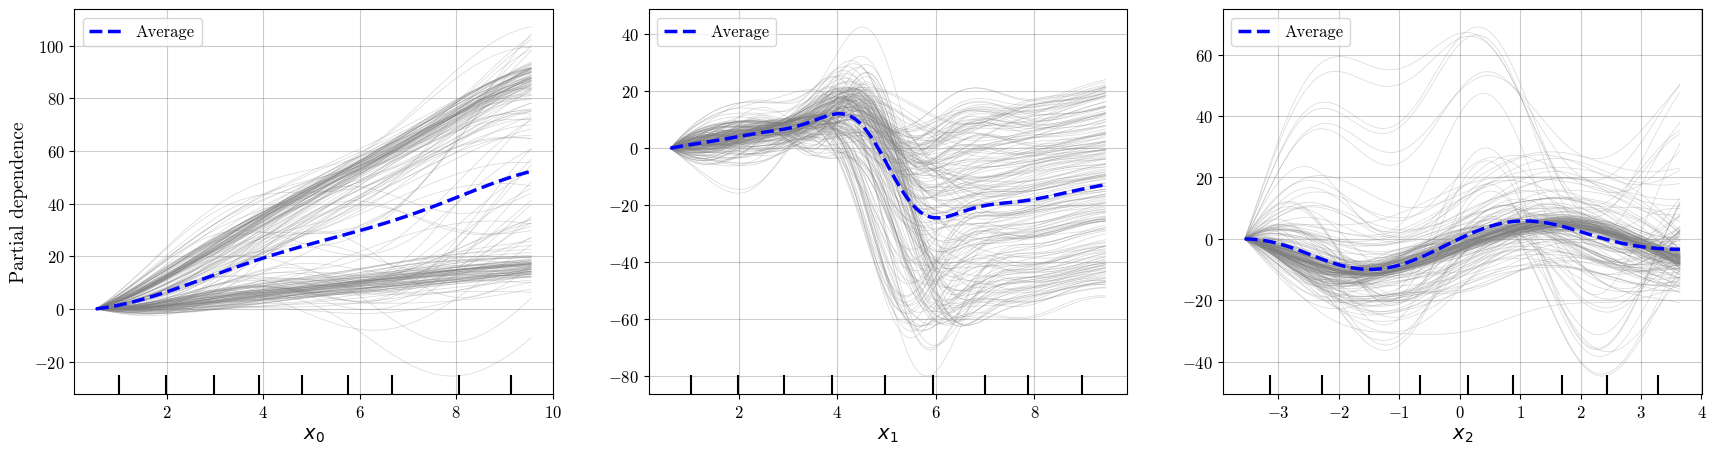

In [41]:
%%time
model = sm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    grid_resolution=100, 
    kind='both',
    # feature_names=feature_names,
    centered=True
    )

CPU times: user 247 ms, sys: 8.17 ms, total: 256 ms
Wall time: 253 ms


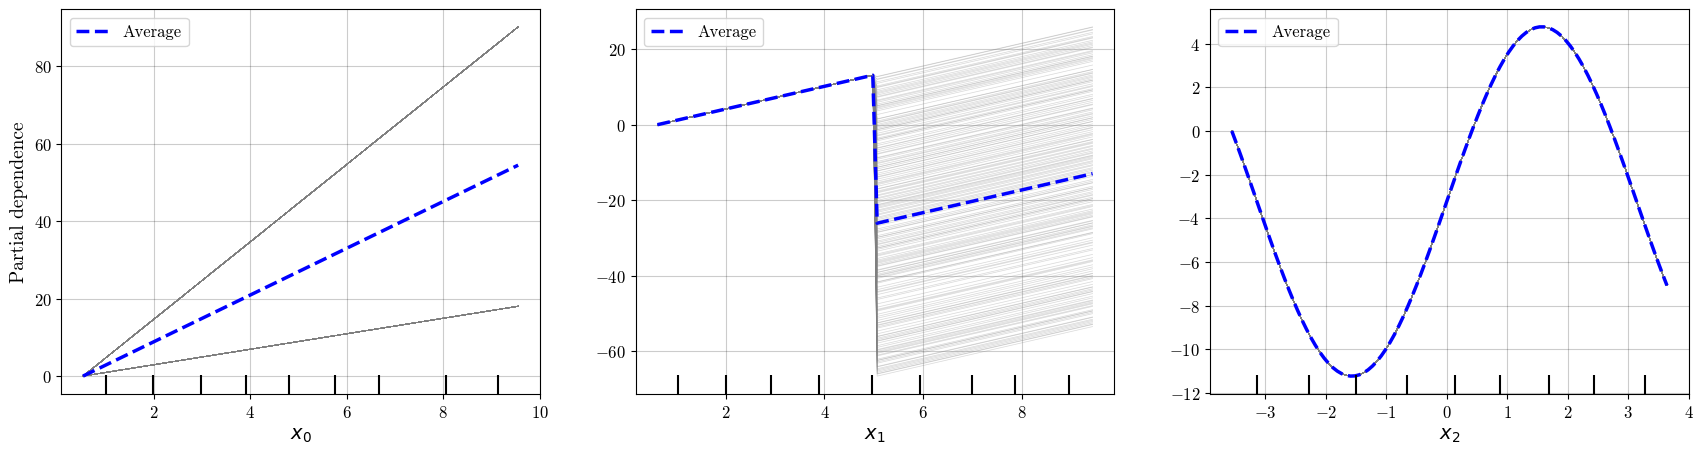

In [43]:
%%time
model = gtm
X = X_tr
features = [i for i in range(X_tr.shape[1])]

pdd = PartialDependenceDisplay.from_surrogate_model(
    model, 
    X, 
    features, 
    grid_resolution=100, 
    kind='both',
    # feature_names=feature_names,
    centered=True
    )

In [44]:
%%time
instances = X_tr
model = sm
X = X_tr
explainer_train = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X, 
    # feature_names=feature_names,
)

CPU times: user 459 ms, sys: 3.99 ms, total: 463 ms
Wall time: 165 ms


In [45]:
%%time
instances = X_tr
model = gtm
X = X_tr
explainer_train_true = ShapDisplay.from_surrogate_model(
    instances, 
    model, 
    X, 
    # feature_names=feature_names,
)

CPU times: user 135 ms, sys: 5.66 ms, total: 140 ms
Wall time: 49 ms


CPU times: user 750 ms, sys: 24.4 ms, total: 774 ms
Wall time: 278 ms


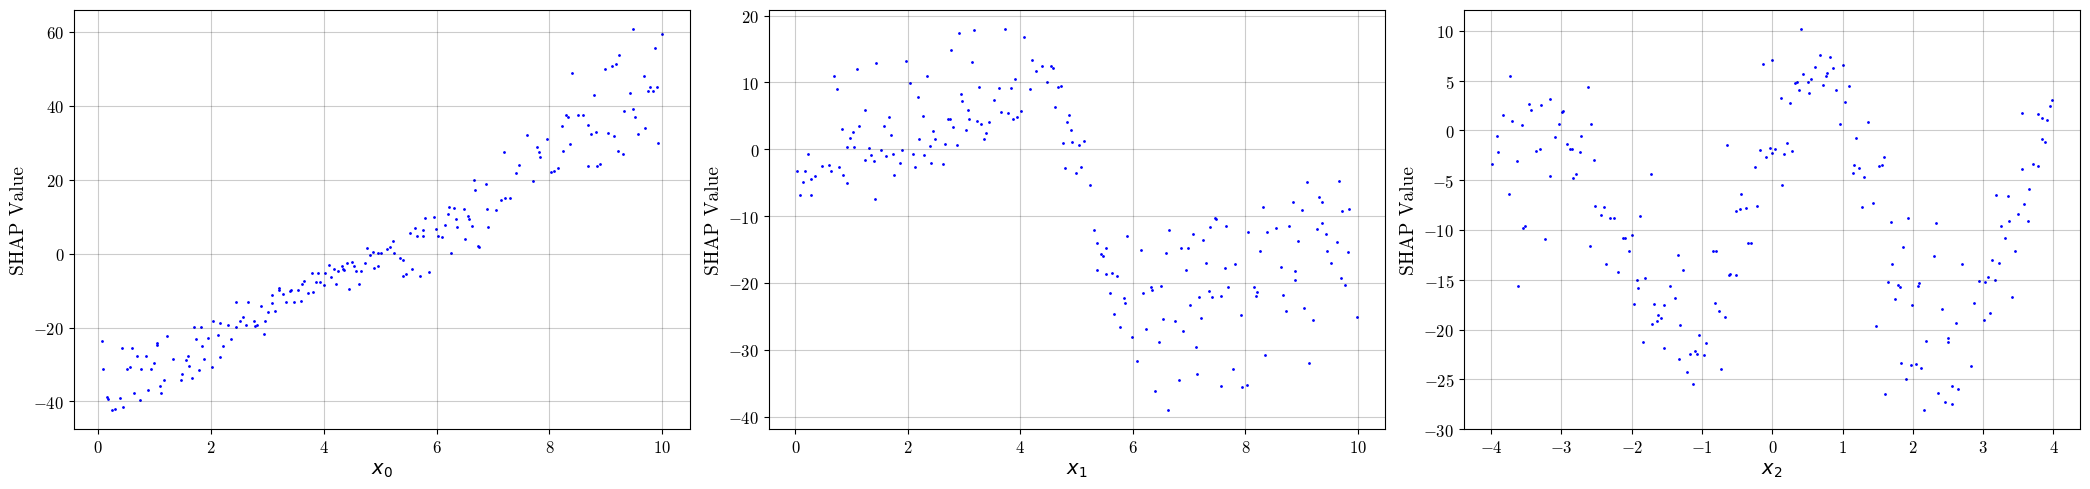

In [46]:
%%time
features = [i for i in range(X_tr.shape[1])]

explainer_train.dependence_plot(features)

CPU times: user 461 ms, sys: 7.44 ms, total: 468 ms
Wall time: 180 ms


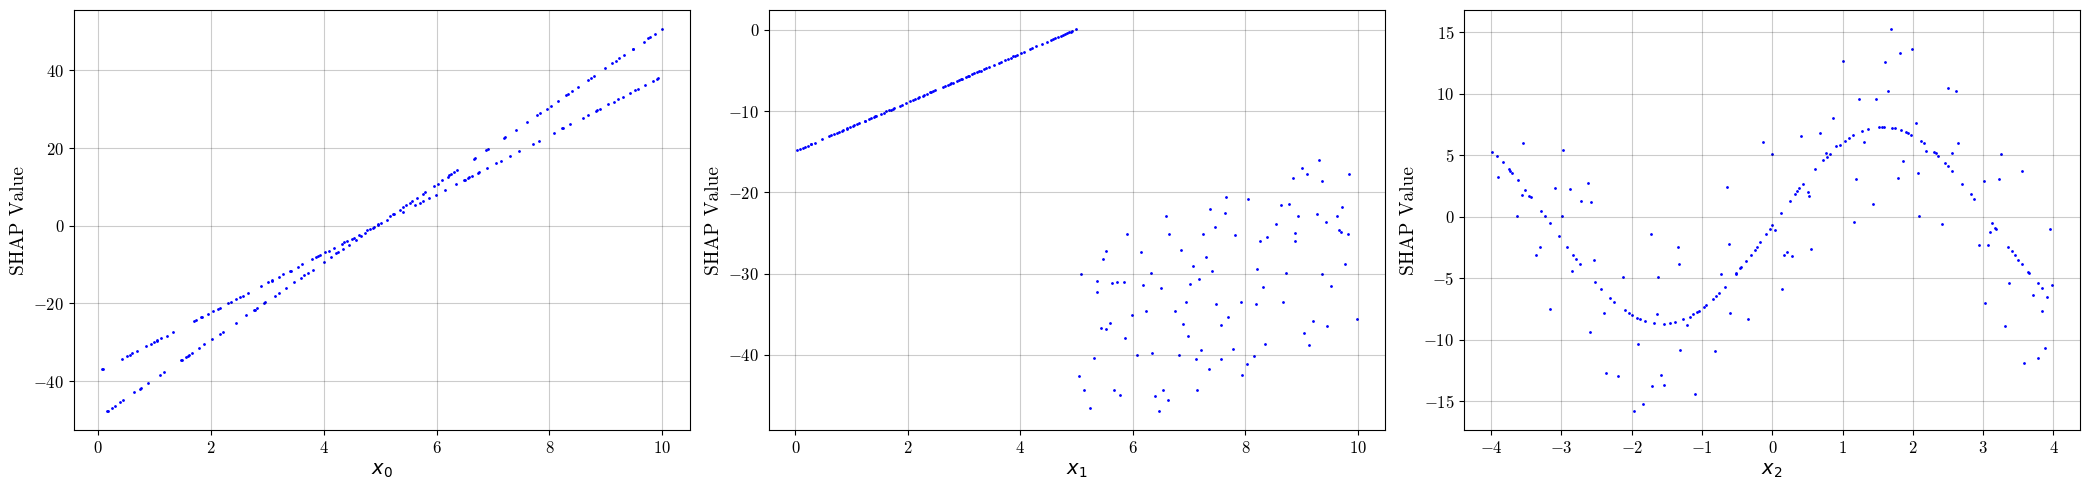

In [47]:
%%time
features = [i for i in range(X_tr.shape[1])]

explainer_train_true.dependence_plot(features)

CPU times: user 384 ms, sys: 7.98 ms, total: 392 ms
Wall time: 182 ms


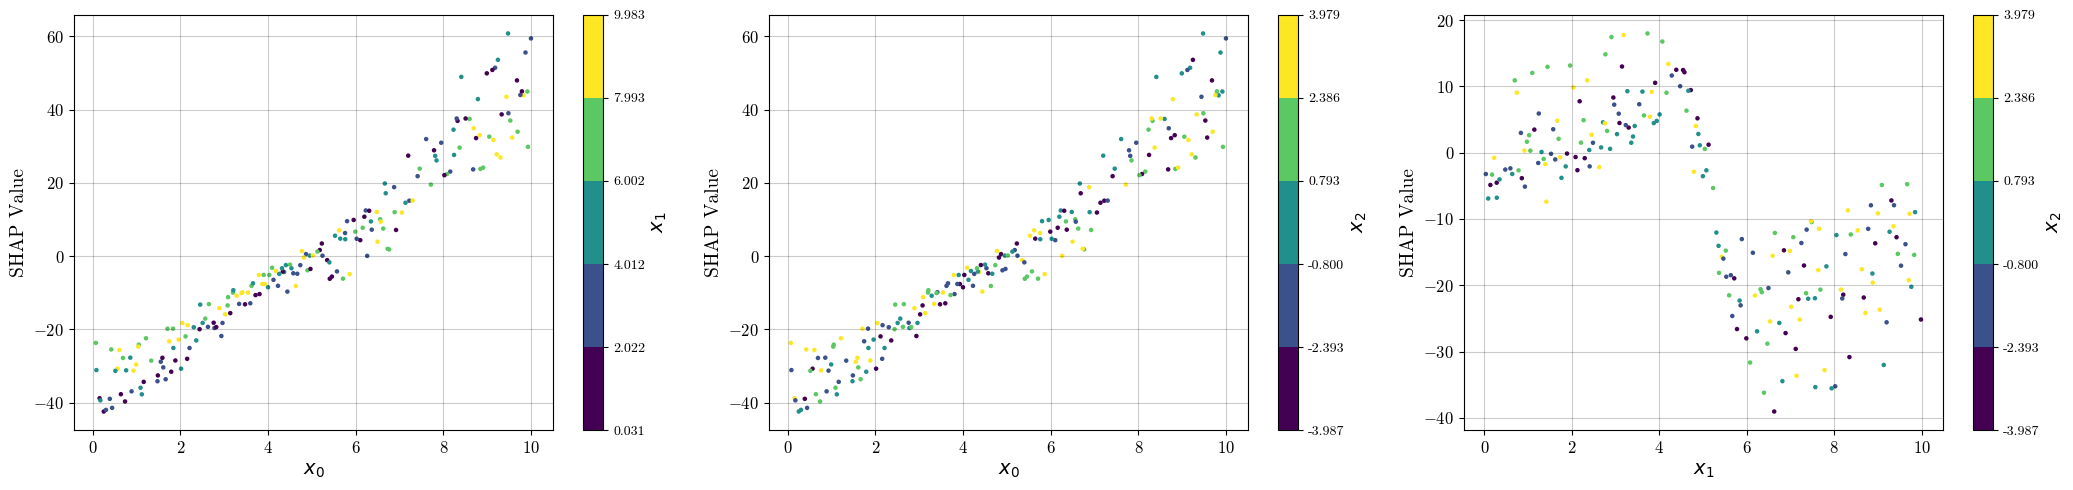

In [49]:
%%time
feature_pairs = [(0, 1), (0, 2), (1, 2)]
explainer_train.interaction_plot(
    feature_pairs, 
    n_color=5,
)

CPU times: user 378 ms, sys: 8.95 ms, total: 387 ms
Wall time: 180 ms


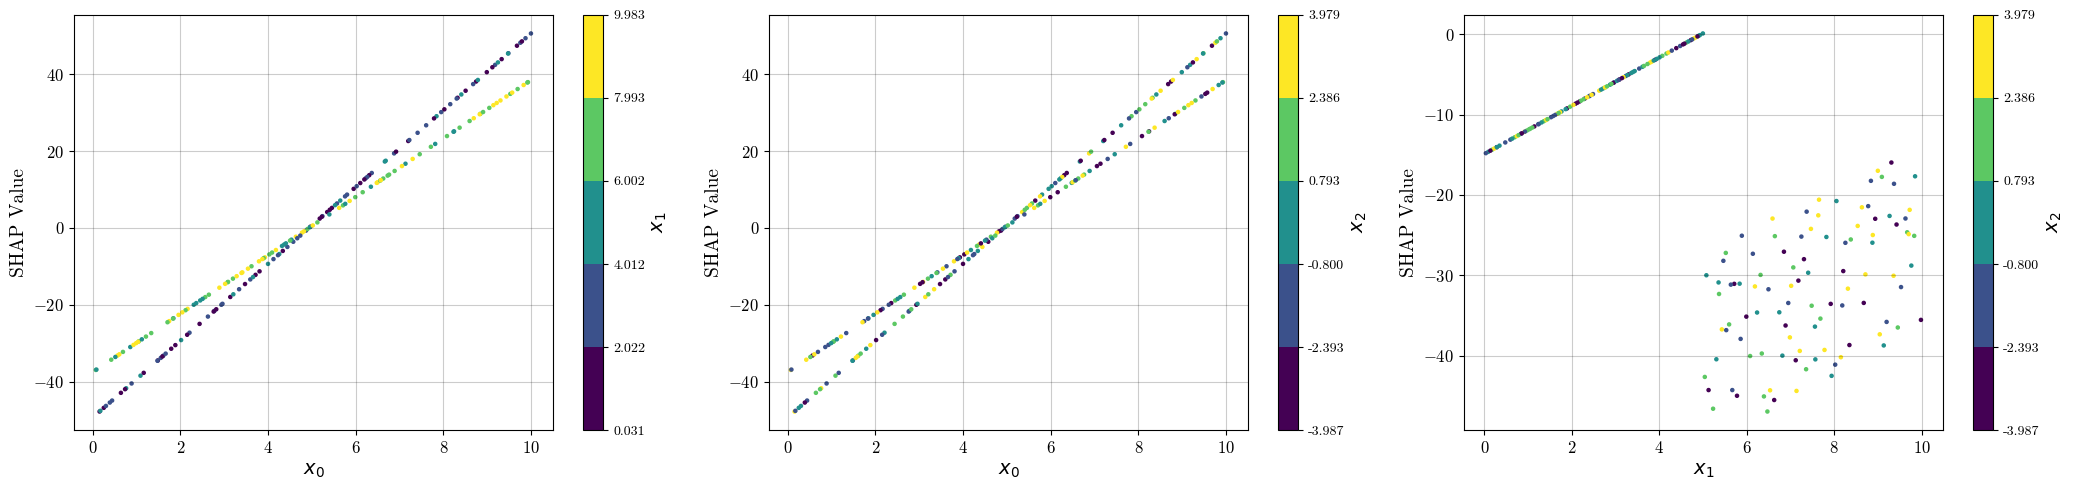

In [48]:
%%time
feature_pairs = [(0, 1), (0, 2), (1, 2)]
explainer_train_true.interaction_plot(
    feature_pairs, 
    n_color=5,
)

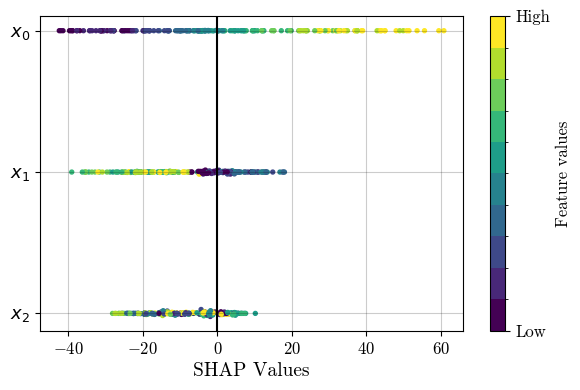

In [50]:
explainer_train.summary_plot()

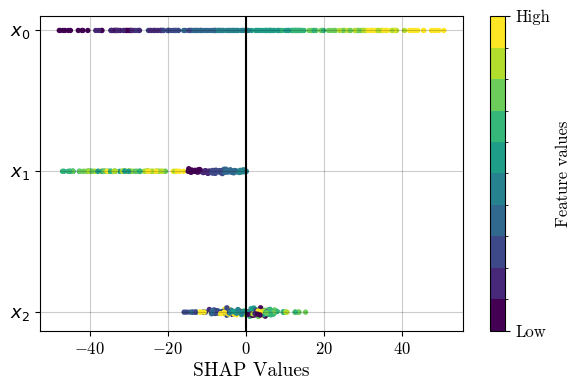

In [51]:
explainer_train_true.summary_plot()